# HEALpixel functions 

Two main packages are available for manipulating HEALpixel maps: Astropy's astropy_healpix and healpy.  

In [1]:
import healpy as hp
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, SkyCoord, TETE
import numpy as np
from mw_plot import MWSkyMap
import matplotlib.pyplot as plt
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import regions
import config_utils
import survey_footprints

In [ ]:
# Example query parameters; all units in degrees
l_center = 0.0
b_center = 0.0
radius = 1.0

NSIDE = 256
NPIX = hp.nside2npix(NSIDE)

In [ ]:
# Use Astropy functions to calculate the HEALpixels that lie within the circular region
# RING orientation is used since this is the HEALpy default 
ahp = HEALPix(nside=NSIDE, order='ring', frame=Galactic())

pixels1 = ahp.cone_search_lonlat(
                l_center * u.deg,
                b_center * u.deg,
                radius=radius * u.deg
            )
print(pixels1, len(pixels1))

map1 = np.zeros(NPIX)
map1[pixels1] = 1.0

In [ ]:
fig = plt.figure(1,(10,10))
hp.mollview(map1)
hp.graticule()
plt.tight_layout()

In [ ]:
plt.close()

In [ ]:
# Using HEALpy to perform an equivalent HEALpixel cone search
s = SkyCoord(
    l_center,
    b_center,
    frame=Galactic(),
    unit=(u.deg, u.deg)
)
print(s)
s = s.transform_to('icrs')
print(s)

phi = np.deg2rad(s.ra.deg)
theta = (np.pi / 2.0) - np.deg2rad(s.dec.deg)
r = np.deg2rad(radius)
print(phi, theta, r)

xyz = hp.ang2vec(theta, phi)
print(NSIDE, xyz)
pixels2 = hp.query_disc(NSIDE, xyz, r)

print(pixels2, len(pixels2))

map2 = np.zeros(NPIX)
map2[pixels2] = 1.0

In [ ]:
fig = plt.figure(1,(10,10))
hp.mollview(map2)
hp.graticule()
plt.tight_layout()

By default HEALpy produces a map in equatorial coordinates.  These can be rotated to return to Galactic coordinates.

In [ ]:
def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    """Rotates healpix map from one system to the other. Returns reordered healpy map.
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2.
    Original code by Xiaolong Li
    """

    # For reasons I don't understand, entering in ['C', 'G'] seems to do the
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.

    # Heavily influenced by stack overflow solution here:
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy

    nside = hp.npix2nside(len(hpmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)

    return rot_map

In [ ]:
map3 = rotateHealpix(map2, transf=['G','C'])

In [ ]:
fig = plt.figure(1,(10,10))
hp.mollview(map3)
hp.graticule()
plt.tight_layout()

In [ ]:
pixels3 = np.where(map3 > 0.0)[0]
print(pixels3, len(pixels3))

Check this works as expected with CelestialRegions

In [ ]:
test_case = {"TEST": {
                "F213": [
                {"pointing": [0.0, 0.0, 2.0],
                "nvisits": 60,
                "duration": 0.4,
                "visit_interval": [0.13],
                "name": "NGC6528"},
                ],
                "region": "Test field",
                "comment": "Test",
                "proper_motions": "False",
                "time_domain": "True",
                "cadence": "1min over 8hrs",
                "n_visits_per_field": 60,
                "category": "high_cadence",
                "ready_for_use": "True",
                "extended_object_catalog": "False",
                "code": "WPXX"
                }
            }
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))
test_science_cases = regions.build_region_maps(sim_config, test_case)
print(test_science_cases)
r = test_science_cases['TEST']['F213'][0]

In [ ]:
fig = plt.figure(1,(10,10))
hp.mollview(r.region_map, title='Original pixel map')
hp.graticule()
plt.tight_layout()

In [ ]:
r.rot_pixels()

fig = plt.figure(1,(10,10))
hp.mollview(r.region_map, title='Rotated pixel map')
hp.graticule()
plt.tight_layout()

Test loading of survey footprints

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

rubin_map = survey_footprints.load_rubin_galplane_footprint(sim_config, '/Users/rstreet/software/rgps/')
rubin_map

/Users/rstreet/software/rgps/config/rubin_galplane_survey_footprint.json


array([0., 0., 0., ..., 0., 0., 0.])

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_3241/3091875413.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

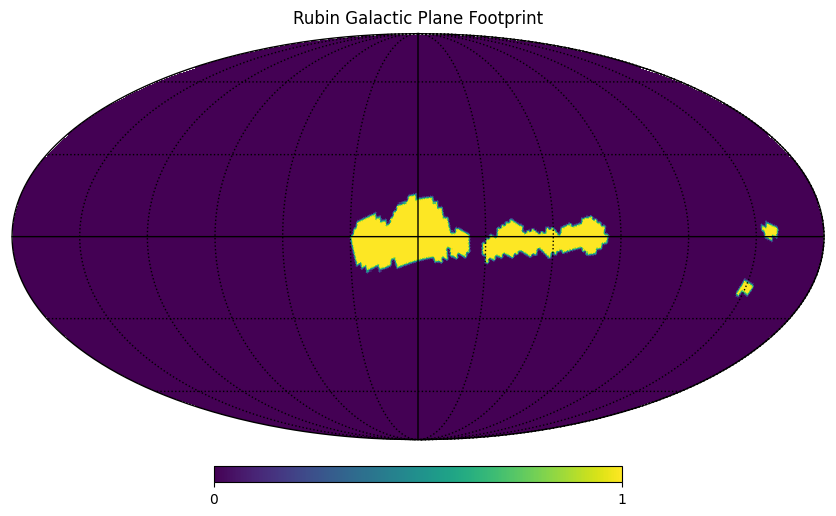

In [3]:
fig = plt.figure(1,(10,10))
hp.mollview(rubin_map, title='Rubin Galactic Plane Footprint')
hp.graticule()
plt.tight_layout()